In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from random import randrange

# Data for final consumption and total output

For this case study, we use the input-output data of Germany. The data for the initial output level and final consumption level per industry as well as the supply and demand shock data is taken from:

Pichler, A. and Farmer, J. D. (2021b). Simultaneous supply and demand constraints in
input–output networks: the case of covid-19 in Germany, Italy and Spain (Version V1).
Zenodo. https://doi.org/10.5281/zenodo.4326815

## Final consumption

**We define the initial and maximal consumption for each industry**

In [2]:
fdata = pd.read_csv('fdata_ita.csv', sep = ',')
fdata.head()
f_0 = fdata.iloc[:,1].astype('float')
f_max = np.array(fdata.iloc[:,3].astype('float'))
demand_shock = np.zeros(f_max.shape[0])
for i in range (0,f_max.shape[0]):
    demand_shock[i] = round(1- f_max[i]/f_0[i],3)
    
demand_shock = np.array(demand_shock)

## Total output

In [3]:
xdata =  pd.read_csv('xdata_ita.csv', sep = ',')
xdata.tail()   
x_0 = xdata.iloc[:,1].astype('float')
x_max = np.array(xdata.iloc[:,3].astype('float'))
supply_shock = np.zeros(x_max.shape[0])
for i in range (0,x_max.shape[0]):
    supply_shock[i] = round(1- x_max[i]/x_0[i],6)
    
supply_shock = np.array(supply_shock)

# IO table 

In [4]:
df = pd.read_csv('ita_wiot.csv',sep = ',',low_memory=False)

### Intermediate demand matrix

In [5]:
Z = pd.read_csv('ita_Zmatrix.csv', sep=',', low_memory=False)
Z =  Z.iloc[:,1:]# leaving out industries U and T
Z = Z.astype('float')
Z = np.array(Z)
N = Z.shape[0]
Z.shape

(55, 55)

**Creating matrix A**

In [6]:
df = df.iloc[:,1:]# leaving out industries U and T
df = df.astype('float')
df.shape
A = np.array(df)
N = A.shape[0]
A.shape

(55, 55)

In [7]:
x_0 = np.array(x_0)
f_0 = np.array(f_0)

In [8]:
L = np.linalg.inv(np.identity(N)-A)

# Optimization

### Maximizing total output

In [9]:
def max_output(N,L,A,xmax,fmax):
    z = np.ones(N)
    obj = -np.matmul(np.matrix.transpose(z), L)
    lhs_ineq = np.concatenate((-L,L))
    rhs_ineq = np.concatenate((np.zeros(N), xmax))
    
    bnd = []
    for i in range (0,N):
        bnd.append((0,fmax[i]))
    
    result = linprog(c = obj, A_ub= lhs_ineq, b_ub= rhs_ineq, bounds = bnd)
    
    optimal_output = -result.fun
    
    optimal_f = np.ones(N)
    for i in range(0,N):
        optimal_f[i] = result.x[i]
    
    return result.success, optimal_output/sum(x_0), sum(optimal_f)/sum(f_0)

### Maximizing final consumption

In [10]:
def max_consumption(N,L,A,xmax,fmax):
    z = np.ones(N)
    obj2 = -np.matmul(np.matrix.transpose(z), np.identity(N)-A)
    lhs_ineq2 = np.concatenate((-(np.identity(N)-A), np.identity(N)-A))
    rhs_ineq2 = np.concatenate((np.zeros(N), fmax))
    
    bnd2 = []
    for i in range (0,N):
        bnd2.append((0,xmax[i]))
        
    result2 = linprog(c = obj2, A_ub= lhs_ineq2, b_ub= rhs_ineq2, bounds= bnd2)
    optimal_f_2 = -result2.fun
    
    optimal_output_2 = np.ones(N)
    for i in range(0,N):
        optimal_output_2[i] = round(result2.x[i])
        
    return result2.success, sum(optimal_output_2)/sum(x_0), optimal_f_2/sum(f_0)

# Rationing

In [11]:
f_max = f_max[:54]
x_max = x_max[:54]
A = A[:54,:54]
Z = Z[:54,:54]
N = 54
x_0 = x_0[:54]
f_0 = f_0[:54]
L = np.linalg.inv(np.identity(N)-A)
supply_shock = np.array(supply_shock[:54])
demand_shock = np.array(demand_shock[:54])

## Proportional Rationing

In [12]:
def algo_proportional(A, L, fmax, xmax, TT, prioritize="no"):
    x = [0]
    fvec = []          # initial demand vector
    fvec.append(fmax)
    r = [0]            # output constraints
    s = [0]            # input bottlenecks 
    d = [0]            # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]

    list_ = [1] 
    t=1
    epsilon = 1e-6
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        r.append(np.ones(len(xmax)))
        s.append(np.ones(len(xmax)))
        fvec.append(np.ones(len(xmax)))
        x.append(np.ones(len(xmax)))
        d.append(np.ones(len(xmax)))
        
        ##########################################
        ########### Output constraints ###########
        ##########################################
        for i in range (0,len(x_max)):
            r[t][i] = xmax[i]/d[t][i]
        #print('Output constraints:{}'.format(r[t]))
        
        ##########################################
        ########### Input bottlenecks ############
        ##########################################
        for i in range(0,len(x_max)):
            for j in range(0,len(x_max)):
                if A[j][i] > 0: 
                    list_.append(r[t][j])
            s[t][i] = min(list_)
            list_ = [1]
        #print('Input bottlenecks:{}'.format(s[t]))
        
        ##############################################
        ########### Constrained Production ###########
        ##############################################
        for i in range(0,len(xmax)):
            x[t][i] = min(xmax[i], s[t][i]*d[t][i])
        #print('Constrained production:{}'.format(x[t]))
        
        ##############################################
        ############ Constrained Delivery ############
        ##############################################
        for i in range(0,len(xmax)):
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],x[t]),0)
        #print('Constrained delivery:{}'.format(fvec[t]))
        
        ###############################################
        ############ New Aggregated Demand ############
        ###############################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
        t=t+1
        #print('Aggregated Demand:         {}'.format(d[t]))
        if t == TT:
            print("Algoritm did not converge")
            
    return sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t, x[t-1], fvec[t-1]


# Direct versus Indirect shocks

In [13]:
direct_shock = (sum(x_max)/sum(x_0),sum(f_max)/sum(f_0))
direct_shock

direct_shocks = np.zeros(54)
for i in range(54):
    direct_shocks[i] = 1-x_max[i]/x_0[i]
direct_shock

direct_shocks_f = np.zeros(54)
for i in range(54):
    direct_shocks_f[i] = 1-f_max[i]/f_0[i]
direct_shocks_f

array([9.98785890e-02, 3.82343835e-02, 1.00000000e-01, 9.99506800e-02,
       9.99063186e-02, 9.98695012e-02, 9.94444564e-02, 9.99646212e-02,
       9.99371577e-02, 9.99884660e-02, 9.98802030e-02, 9.77490980e-02,
       9.99462681e-02, 9.98766560e-02, 9.99679092e-02, 9.98838944e-02,
       9.98317327e-02, 9.98592224e-02, 9.99440685e-02, 9.99430029e-02,
       9.97995810e-02, 9.99160962e-02, 9.99481915e-02, 1.24668415e-02,
       6.05242218e-03, 1.72337185e-02, 9.87874427e-02, 9.98933010e-02,
       9.85340279e-02, 9.76352734e-02, 5.52431913e-01, 4.72643427e-01,
       4.72788174e-01, 3.34714053e-01, 3.43234391e-02, 7.90505564e-01,
       4.00827653e-02, 3.46055278e-02, 3.01042309e-02, 8.48399924e-02,
       1.59935321e-02, 1.10906842e-02, 4.89602880e-02, 5.48565439e-03,
       5.20857755e-02, 8.35910240e-02, 9.80099401e-02, 9.18149704e-02,
       5.01673294e-02, 4.94966900e-02, 2.76922319e-04, 2.25262440e-04,
       1.46021152e-03, 4.65514633e-02])

In [14]:
result_proportional = algo_proportional(A, L, f_max, x_max, TT = 30, prioritize="no")
result_proportional

result_x = result_proportional[3]
shocks_proportional = np.zeros(54)
for i in range(54):
    shocks_proportional[i] = 1-result_x[i]/x_0[i]

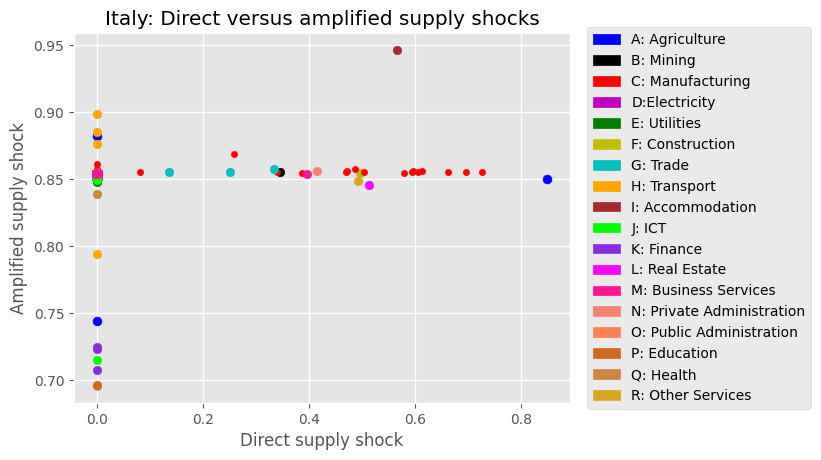

In [15]:
plt.style.use('ggplot')
plt.title("Italy: Direct versus amplified supply shocks")
plt.grid(visible=None, which='major', axis='both', linestyle='-', linewidth=1)


for i in range(0,3):
    plt.scatter(direct_shocks[i], shocks_proportional[i], s=40, marker = 'o', color = 'b')
    
plt.scatter(direct_shocks[3], shocks_proportional[3], marker = 'o', color = 'black')
plt.scatter(direct_shocks[23], shocks_proportional[23], marker = 's',s=50, color = 'm')
plt.scatter(direct_shocks[26], shocks_proportional[26], marker = 'o', color = 'y')
plt.scatter(direct_shocks[35], shocks_proportional[35], marker = 'o', color = 'brown')
plt.scatter(direct_shocks[43], shocks_proportional[43], marker = 'o', color = 'magenta')

for i in range(4,23):
    plt.scatter(direct_shocks[i], shocks_proportional[i], s = 20, marker = 'o', color = 'r')

for i in range(24,26):
    plt.scatter(direct_shocks[i], shocks_proportional[i], marker = 'o', color = 'g')

for i in range(27,30):
    plt.scatter(direct_shocks[i], shocks_proportional[i], marker = 'o', color = 'c')
for i in range(30,35):
    plt.scatter(direct_shocks[i], shocks_proportional[i], marker = 'o', color = 'orange')
    
for i in range(36,40):
    plt.scatter(direct_shocks[i], shocks_proportional[i], marker = 'o', color = 'lime')
    
for i in range(40,43):
    plt.scatter(direct_shocks[i], shocks_proportional[i], marker = 'o', color = 'blueviolet')
    
for i in range(44,49):
    plt.scatter(direct_shocks[i], shocks_proportional[i], marker = 'o', color = 'deeppink')

    
plt.scatter(direct_shocks[49], shocks_proportional[49], marker = 'o', color = 'salmon')
plt.scatter(direct_shocks[50], shocks_proportional[50], marker = 'o', color = 'coral')
plt.scatter(direct_shocks[51], shocks_proportional[51], marker = 'o', color = 'chocolate')
plt.scatter(direct_shocks[52], shocks_proportional[52], marker = 'o', color = 'peru')
plt.scatter(direct_shocks[53], shocks_proportional[53], marker = 'o', color = 'goldenrod')
#plt.scatter(direct_shocks[54], shocks_proportional[54], marker = 'o', color = 'olive')


import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='b', label='A: Agriculture')
black_patch =  mpatches.Patch(color='black', label='B: Mining')
red_patch = mpatches.Patch(color='r', label='C: Manufacturing')
purple_patch = mpatches.Patch(color='m', label = 'D:Electricity')
green_patch = mpatches.Patch(color='g', label='E: Utilities')
yellow_patch = mpatches.Patch(color='y', label='F: Construction')
cyan_patch = mpatches.Patch(color='c', label='G: Trade')
orange_patch = mpatches.Patch(color='orange', label='H: Transport')
brown_patch = mpatches.Patch(color='brown', label='I: Accommodation')
lime_patch = mpatches.Patch(color='lime', label='J: ICT')
violet_patch = mpatches.Patch(color='blueviolet', label='K: Finance')
magenta_patch = mpatches.Patch(color='magenta', label='L: Real Estate')
pink_patch = mpatches.Patch(color= 'deeppink', label = 'M: Business Services')

salmon_patch = mpatches.Patch(color='salmon', label='N: Private Administration')
coral_patch = mpatches.Patch(color='coral', label='O: Public Administration')
chocolate_patch = mpatches.Patch(color='chocolate', label='P: Education')
peru_patch = mpatches.Patch(color='peru', label='Q: Health')
goldenrod_patch = mpatches.Patch(color='goldenrod', label='R: Other Services')
#olive_patch = mpatches.Patch(color= 'olive', label = 'T: Household Activities')

plt.legend(loc='right', bbox_to_anchor=(1.5, 0.5), handles=[blue_patch, black_patch, red_patch, purple_patch, green_patch, yellow_patch, cyan_patch, orange_patch, brown_patch, lime_patch, violet_patch, 
                    magenta_patch, pink_patch, salmon_patch, coral_patch, chocolate_patch, peru_patch, goldenrod_patch])

#plt.xlim(-0.05, 1) 
#plt.ylim(-0.00,1)
#plt.rcParams['text.usetex'] = True
plt.xlabel('Direct supply shock')
plt.ylabel("Amplified supply shock")
#plt.legend(['Agriculture', 'Mining'])
plt.savefig('plot_ita_direct_apmlified.png',bbox_inches='tight')

In [16]:
result_proportional
result_f = result_proportional[4]
shocks_proportional_d = np.zeros(54)
for i in range(54):
    shocks_proportional_d[i] = 1-result_f[i]/f_0[i]

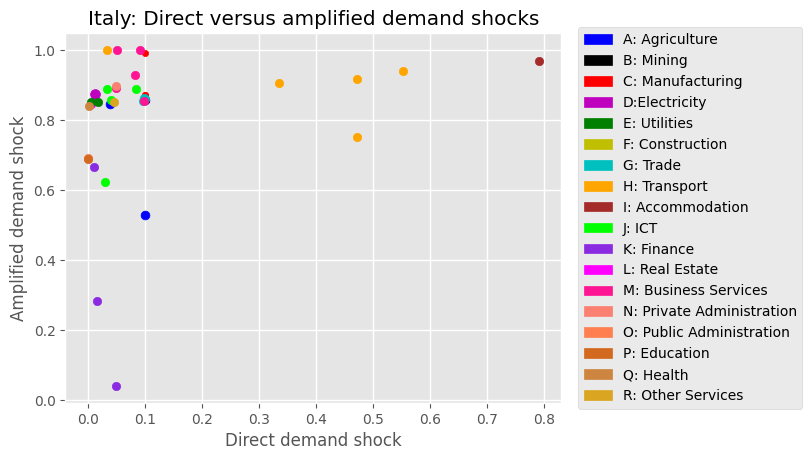

In [17]:
plt.style.use('ggplot')
plt.title("Italy: Direct versus amplified demand shocks")
plt.grid(visible=None, which='major', axis='both', linestyle='-', linewidth=1)
#fig = plt.plot()

for i in range(0,3):
    plt.scatter(direct_shocks_f[i], shocks_proportional_d[i], s=40, marker = 'o', color = 'b')
    
plt.scatter(direct_shocks_f[3], shocks_proportional_d[3], marker = 'o', color = 'black')
plt.scatter(direct_shocks_f[23], shocks_proportional_d[23], marker = 'o',s=50, color = 'm')
plt.scatter(direct_shocks_f[26], shocks_proportional_d[26], marker = 'o', color = 'y')
plt.scatter(direct_shocks_f[35], shocks_proportional_d[35], marker = 'o', color = 'brown')
plt.scatter(direct_shocks_f[43], shocks_proportional_d[43], marker = 'o', color = 'magenta')

for i in range(4,23):
    plt.scatter(direct_shocks_f[i], shocks_proportional_d[i], s = 20, marker = 'o', color = 'r')

for i in range(24,26):
    plt.scatter(direct_shocks_f[i], shocks_proportional_d[i], marker = 'o', color = 'g')

for i in range(27,30):
    plt.scatter(direct_shocks_f[i], shocks_proportional_d[i], marker = 'o', color = 'c')
for i in range(30,35):
    plt.scatter(direct_shocks_f[i], shocks_proportional_d[i], marker = 'o', color = 'orange')
    
for i in range(36,40):
    plt.scatter(direct_shocks_f[i], shocks_proportional_d[i], marker = 'o', color = 'lime')
    
for i in range(40,43):
    plt.scatter(direct_shocks_f[i], shocks_proportional_d[i], marker = 'o', color = 'blueviolet')
    
for i in range(44,49):
    plt.scatter(direct_shocks_f[i], shocks_proportional_d[i], marker = 'o', color = 'deeppink')

    
plt.scatter(direct_shocks_f[49], shocks_proportional_d[49], marker = 'o', color = 'salmon')
plt.scatter(direct_shocks_f[50], shocks_proportional_d[50], marker = 'o', color = 'coral')
plt.scatter(direct_shocks_f[51], shocks_proportional_d[51], marker = 'o', color = 'chocolate')
plt.scatter(direct_shocks_f[52], shocks_proportional_d[52], marker = 'o', color = 'peru')
plt.scatter(direct_shocks_f[53], shocks_proportional_d[53], marker = 'o', color = 'goldenrod')
#plt.scatter(direct_shocks[54], shocks_proportional[54], marker = 'o', color = 'olive')


import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='b', label='A: Agriculture')
black_patch =  mpatches.Patch(color='black', label='B: Mining')
red_patch = mpatches.Patch(color='r', label='C: Manufacturing')
purple_patch = mpatches.Patch(color='m', label = 'D:Electricity')
green_patch = mpatches.Patch(color='g', label='E: Utilities')
yellow_patch = mpatches.Patch(color='y', label='F: Construction')
cyan_patch = mpatches.Patch(color='c', label='G: Trade')
orange_patch = mpatches.Patch(color='orange', label='H: Transport')
brown_patch = mpatches.Patch(color='brown', label='I: Accommodation')
lime_patch = mpatches.Patch(color='lime', label='J: ICT')
violet_patch = mpatches.Patch(color='blueviolet', label='K: Finance')
magenta_patch = mpatches.Patch(color='magenta', label='L: Real Estate')
pink_patch = mpatches.Patch(color= 'deeppink', label = 'M: Business Services')

salmon_patch = mpatches.Patch(color='salmon', label='N: Private Administration')
coral_patch = mpatches.Patch(color='coral', label='O: Public Administration')
chocolate_patch = mpatches.Patch(color='chocolate', label='P: Education')
peru_patch = mpatches.Patch(color='peru', label='Q: Health')
goldenrod_patch = mpatches.Patch(color='goldenrod', label='R: Other Services')
#olive_patch = mpatches.Patch(color= 'olive', label = 'T: Household Activities')

plt.legend(loc='right', bbox_to_anchor=(1.5, 0.5), handles=[blue_patch, black_patch, red_patch, purple_patch, green_patch, yellow_patch, cyan_patch, orange_patch, brown_patch, lime_patch, violet_patch, 
                    magenta_patch, pink_patch, salmon_patch, coral_patch, chocolate_patch, peru_patch, goldenrod_patch])

#plt.xlim(-0.05, 1) 
#plt.ylim(0.79,1)
#plt.rcParams['text.usetex'] = True
plt.xlabel('Direct demand shock')
plt.ylabel("Amplified demand shock")
#plt.legend(['Agriculture', 'Mining'])
#plt.set_size_inches(10, 10)
plt.savefig('plot_ita_direct_apmlified_demand.png', bbox_inches='tight')

## Mixed priority/proportional rationing

We implement the rationing algorithm in the following way:
1. Industries determine their total demand as if there were no supply-side constraints, $d = Lf^{\text{max}}$;
2. Industries evaluate if they are able to satisfy demand given their constrained production capacities;
3. Industries that only partially satisfy demand, create a bottleneck;
4. Industries reduce their production according to the largest input bottleneck (assumption of fixed recipes);
5. The total amount of goods delivered to the final consumer is computed;
6. Iterate 1-5 until there are no input constraints left.

Formulas:

$$ r_i[t] = \frac{x_i^{\text{max}}}{\sum_{j}A_{ij}d_j[t]} $$

$$ s_i[t] = min_j \{r_j[t], 1\} $$

$$ x_i[t] = \text{min}\{x_i^{\text{max}}, s_i[t]d_i[t]\} $$

$$ f_i[t] = \text{max} \Big\{ x_i[t] - \sum_{i} a_{ij} x_j[t], 0 \Big\}$$

$$ d_i[t+1] = \sum_{j} l_{ij} f_j[t] $$

The algorithm converges to a new feasible economic allocation if $d_i[t+1] = d_i[t]$ for all i.

*Implementation*

In [18]:
def algo_mixed(A, L, fmax, xmax, TT,prioritize="yes"):
    x = [0]
    fvec = [] # initial demand vector
    fvec.append(fmax)
    r = [0]   # output constraints
    s = [0]   # input bottlenecks 
    d = [0]   # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]
    
    list_ = [1] 
    t=1
    epsilon = 1e-6
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        r.append(np.ones(len(xmax)))
        s.append(np.ones(len(xmax)))
        fvec.append(np.ones(len(xmax)))
        x.append(np.ones(len(xmax)))
        d.append(np.ones(len(xmax)))
        
        ##########################################
        ########### Output constraints ###########
        ##########################################
        for i in range (0,len(x_max)):
            r[t][i] = xmax[i]/np.matmul(A[i],d[t])
        #print('Output constraints:         {}'.format(r[t]))
        
        ##########################################
        ########### Input bottlenecks ############
        ##########################################
        for i in range(0,len(x_max)):
            for j in range(0,len(x_max)):
                if A[j][i] > 0:
                    list_.append(r[t][j])
            s[t][i] = min(list_)
            list_ = [1]
        #print('Input bottlenecks:         {}'.format(s[t]))
        
        ##############################################
        ########### Constrained Production ###########
        ##############################################
        for i in range(0,len(xmax)):
            x[t][i] = min(xmax[i], s[t][i]*d[t][i])
            #print(s[t][i]*d[t][i])
        
        ##############################################
        ############ Constrained Delivery ############
        ##############################################
        
        for i in range(0,len(xmax)):
            #print(np.matmul(A[i],s[t]*d[t]))
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],x[t]),0) 
        #print('Constrained delivery:      {}'.format(fvec[t]))
        
        ###############################################
        ############ New Aggregated Demand ############
        ###############################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
        t=t+1
    
    if t == TT:
        print("Algoritm did not converge")
        
    return sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t

## Priority rationing

Largest first rationing; firms are prioritized over the final consumer. Take
an initial demand vector $f[0] = f$
max as given, implying an initial aggregate demand vector
$d[1] = Lf[0]$. Every firm $i$ ranks each customers based on initial demand size. Let  $h_{ij}$ be the $j$ largest customers of firm $i$: $h_{ij} =
\{k(1), k(2), ..., k(j)
: A_{ik(1)}d_{k(1)} [1] ≥ A_{ik(2)}d_{k(2)} [1] ≥ ... ≥ A_{ik(j)}
d_{k(j)}[1] \}$. By looping over the
index $t = {1, 2, ...}$, the following system is iterated forward:

Formulas:

$$ r_{ij}[t] = \frac{x_i^{\text{max}}}{\sum_{n\in h_{ij}}A_{ih(j)}d_{n_{(j)}}[t]} $$

$$ s_i[t] = min_j \{r_{ji}[t], 1\} $$

$$ x_i[t] = \text{min}\{x_i^{\text{max}}, s_i[t]d_i[t]\} $$

$$ f_i[t] = \text{max} \Big\{ x_i[t] - \sum_{i} a_{ij} x_j[t], 0 \Big\}$$

$$ d_i[t+1] = \sum_{j} l_{ij} f_j[t] $$

The algorithm converges to a new feasible economic allocation if $d_i[t+1] = d_i[t]$ for all i.

In [19]:
def order(A, L, fmax):
    d = np.matmul(L, fmax)
    list_1 = []      # list we will sort
    list_2 = []      # list that will not be sorted to find the original indices
    for i in range(A.shape[0]):
        list_1.append([])
        list_2.append([])
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            list_1[i].append(A[i][j]*d[j])    # list_1[i][j] = list_2[i][j] = A[i][j]*d[j]
            list_2[i].append(A[i][j]*d[j])
        list_1[i].sort(reverse = True)        # we sort list_1: A[i][j]*d[j] >= A[i][j+1]*d[j+1]

    names_ordered=[]
    for i in range(A.shape[0]):
        names_ordered.append([])
    
    for i in range(A.shape[0]):
        for k in list_1[i]:                  # we take the indices of the j+1 (j from 0 to N-1) biggest suppliers of industry i. 
                for l in range(A.shape[0]):    
                    if list_2[i][l] == k:
                        names_ordered[i].append(l)   
    return names_ordered

In [20]:
def algo_priority(A, L, fmax, xmax, ordered, TT, prioritize="yes"):                 
    x = [0]
    fvec = []   # initial demand vector
    fvec.append(fmax)
    rvec = [0]  # output constraints
    s = [0]     # input bottlenecks 
    d = [0]     # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]
    
    list_ = [1] 
    t=1
    epsilon = 1e-6
    
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        rvec.append([np.zeros(N)])
        s.append(np.ones(N))
        fvec.append(np.ones(N))
        x.append(np.ones(N))
        d.append(np.ones(N))
        demand = np.identity(N)
        
        som = 0
        for i in range(0,N):
            for j in range(0,N):
                for k in ordered[i][:j+1]:
                    som = som + A[i][k]*d[t][k] 
                demand[i][j] = som   #demand[i][j] = demand of j'th biggest customers of firm i summed up
                som = 0
        remainder = np.identity(N)
    
        for i in range(0,N):
            for j in range(0,N):
                remainder[i][j] = xmax[i] - demand[i][j]
                
        ####################################################
        ####################### rvec #######################
        ####################################################
        for i in range(0,N):
            rvec[t].append([])
        for i in range(0,N):
            if all(remainder[i][j]>0 for j in range(0,N)):
                rvec[t][i] = np.ones(N) 
            elif all(remainder[i][j]<=0 for j in range(0,N)): 
                rvec[t][i] = np.zeros(N)
                for k in ordered[i][:1]: 
                    rvec[t][i][k] = xmax[i]/demand[i][0]
        
            else: 
                idx = np.where(remainder[i]<=0) # index for partially met demand
                idx_fully = np.where(remainder[i]>0) 
                length = len(idx_fully[0])
                rvec[t][i] = np.zeros(N)
                for l in range(0,length-1):
                    index = ordered[i][l]
                    rvec[t][i][index] = 1
                m = ordered[i][length-1]
                rvec[t][i][m] = remainder[i][length-1]/(demand[i][length]-demand[i][length-1])
          
        #####################################################
        ################# Input bottlenecks #################
        #####################################################
        for i in range(0,N):
            for j in range(0,N):
                if A[j][i]>0:
                    list_.append(rvec[t][j][i])
            s[t][i] = min(list_)
            list_ = [1]   
        #print('Input bottlenecks:         {}'.format(s[t]))
        
        ######################################################
        ############### Constrained Production ###############
        ######################################################
        for i in range(0,N):
            x[t][i] = min(xmax[i], s[t][i]*d[t][i])
        #print(x)
        
        ######################################################
        ################ Constrained Delivery ################
        ######################################################
        for i in range(0,len(xmax)):
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],x[t]),0)
        
        ######################################################
        ################ Aggregated demand ###################
        ######################################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
            
        t=t+1
        if t==TT:
            print("Algorithm did not converge")
            return(None, None)
        #print(d[t])
    return sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t

## Random rationing

In [21]:
def algo_random(A, L, fmax, xmax, runs, prioritize = "random"):
    x = []
    y = []
    while len(x)<runs:
        random_ordered=[]
        for i in range(N):
            random_ordered.append([])
    
        for i in range(N):
            while len(random_ordered[i])<N:
                random = randrange(N)
                while random in random_ordered[i]:
                    random = randrange(N)# we willen nu de indices van de j+1 (j van 0 tot en met N-1) grootste suppliers  
                random_ordered[i].append(random)
                
        result = algo_priority(A, L, fmax, xmax, random_ordered, TT = 25, prioritize="yes")
        if result[0] != None:
            x.append(result[0])
            y.append(result[1])
    return sum(x)/len(x), sum(y)/len(y), len(x)